pip install ultralytics

In [6]:
!pip install pybboxes albumentations==1.3.0 --upgrade typing-extensions torch 
import glob
import json
import os
import random
import re
import shutil
import sys
import time
import warnings
import xml.etree.ElementTree as ET
import zipfile
from collections import defaultdict
from distutils.dir_util import copy_tree
# import imagesize
# import ptitprince as pt
from shutil import copyfile

import albumentations as A
import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import tensorflow as tf
import torch
import yaml
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import ResNet101, ResNet152
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.notebook import tqdm

from augmentation import apply_aug, get_bboxes_list

warnings.filterwarnings('ignore')






class pcbDetection:
    
    """
    clf = central, lient1, client2 중 선택.
    input_img_dir = input으로 들어갈 이미지의 directory.
    clf_isLabel = input으로 들어갈 이미지의 label이 있을 경우 적는다.
    
    """
    
    
    def __init__(self, clf = None, yolo = None, input_img_dir = None, clf_isLabel = False):
        
        if clf == None and yolo == None:
            raise ValueError('model을 입력해주세요.')
                

        if clf != None:
            if clf == 'all':
                self.clf_cli = 'PCB_CLF'
                self.clf = load_model(f"{os.path.join(os.getcwd(), 'model_save_PCB_CLF/model_1.h5')}")

            if clf == 'client1':
                self.clf_cli = 'C1_PCB_CLF'
                self.clf = load_model(f"{os.path.join(os.getcwd(), 'model_save_C1_PCB_CLF/model_2.h5')}")

            if clf == 'client2':
                self.clf_cli = 'C2_PCB_CLF'
                self.clf = load_model(f"{os.path.join(os.getcwd(), 'model_save_C2_PCB_CLF/model_3.h5')}")
                
        if yolo != None:
            if yolo == 'all':
                self.yolo_cli = 'PCB'
                self.yolo_model = f"/home/work/KISTI_PCB2/yolov5/runs/train/{self.yolo_cli}_train_results/weights/best.pt"

            if yolo == 'client1':
                self.yolo_cli = 'C1_PCB'
                self.yolo_model = f"/home/work/KISTI_PCB2/yolov5/runs/train/{self.yolo_cli}_train_results/weights/best.pt"

            if yolo == 'client2':
                self.yolo_cli = 'C2_PCB'
                self.yolo_model = f"/home/work/KISTI_PCB2/yolov5/runs/train/{self.yolo_cli}_train_results/weights/best.pt"
                
            if yolo.startswith('federated'):
                self.yolo_cli = yolo
                num_round = self.yolo_cli.split('_')[-1]
                self.yolo_model = f"/home/work/KISTI_PCB2/yolov5/model{num_round}_vMTRVgfDoeXTT6Dn.pt"
        
        self.img_dir = input_img_dir
        self.clf_isLabel = clf_isLabel
        self.cname = ['BADPCB', 'GOODPCB']
        if yolo != None:
            self.yoloCheck()
        if clf != None:
            self.clfCheck()
    
    
    def yoloCheck(self):
        if self.img_dir != None:          
            self.yolo_type = 0
                
        else:
            self.yolo_type = 1 # 기존꺼 이용.
    
    def yoloResult(self):
        if self.yolo_type == 0:
            self.yoloDetect()
        
        if self.yolo_type == 1:
            self.yoloVal()
            self.yoloDetect()
                
    def yoloVal(self):
        if self.yolo_cli.startswith('federated'):
            num_round = self.yolo_cli.split('_')[-1]
            %run yolov5/val.py --data "/home/work/KISTI_PCB2/PCB/PCB.yaml" --weights "{self.yolo_model}" --task 'test' --name 'PCB_result_final(federated)_round{num_round}' --exist-ok
            
        else:
            %run yolov5/val.py --data "/home/work/KISTI_PCB2/{self.yolo_cli}/PCB.yaml" --weights "{self.yolo_model}" --task 'test' --name '{self.yolo_cli}_result_final(central)' --exist-ok
    
    
    # Detect만 clf와 이어서?
    def yoloDetect(self):
        if self.yolo_cli.startswith('federated'):
            num_round = self.yolo_cli.split('_')[-1]
            %run yolov5/detect.py --source "/home/work/KISTI_PCB2/PCB/test/images" --weights "/{self.yolo_model}" --exist-ok --line-thickness 2 --name 'PCB_detect_results(federated)_round{num_round}'
        
        else:
            %run yolov5/detect.py --source "/home/work/KISTI_PCB2/{self.yolo_cli}/test/images" --weights "{self.yolo_model}" --exist-ok --line-thickness 2 --name '{self.yolo_cli}_detect_results(central)'
        

    def clfCheck(self):
        if self.img_dir != None:          
            if self.clf_isLabel == False: 
                self.clf_type = 0
                self.img, _ = self.load_images_and_labels(self.img_dir)
            else: 
                self.clf_type = 1
                self.img, self.clf_label = self.load_images_and_labels(self.img_dir)
                
        else:
            if self.clf_isLabel == True:
                raise ValueError('input_img_dir를 입력해주세요.')
            else: 
                self.clf_type = 2
                self.img, self.clf_label = self.load_images_and_labels(f'./{self.clf_cli}/test')
    
    def clfResult(self):
                
        if self.clf_type == 1:
            print('평가 지표를 출력하며, 추론 결과를 return합니다.')
            self.printLossAcc()
            self.clfReport()
            self.cfmtx()
            self.showFail()
                
        
        if self.clf_type == 2:
            print('시스템 자체에서 정의한 테스트 데이터를 기반으로 결과를 출력하며, 평가 지표를 출력하며, 추론 결과를 return합니다.')
            self.printLossAcc()
            self.clfReport()
            self.cfmtx()
            self.showFail()
                
        return self.predict()
    
    def load_images_and_labels(self, directory):
    
        labels = []
        images = []
        
        for image_name in os.listdir(directory):

            image_path = os.path.join(directory, image_name)
            
            if 'ipynb_checkpoint' in image_path:
                continue
            
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(416, 416))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            
            # 파일 이름에 'GOODPCB'가 포함되어 있는지 확인
            if self.clf_type > 0:
                if 'GOODPCB' in image_name:
                    clf_isLabel = 1
                else:
                    clf_isLabel = 0
                labels.append(clf_isLabel)   

        images = np.array(images)
        labels = np.array(labels)
        
        return images, labels

    def predict(self):
        y_pred = self.clf.predict(self.img, batch_size=1)
        y_pred = (y_pred > 0.5).astype(int)
        return y_pred

    def printLossAcc(self):
        print()
        print('loss, accuracy 출력')
        print(self.clf.evaluate(self.img, self.clf_label, verbose=2, batch_size=1))
        
    def clfReport(self):
        print()
        print('classification Report 출력')
        y_pred = self.predict()
        y_pred = (y_pred > 0.5).astype(int)
        
        class_report = classification_report(self.clf_label, y_pred, target_names=self.cname)
        print(class_report)
        
    def cfmtx(self):
        # 혼동 행렬 생성
        print()
        print('confusion matrix 출력')
        y_pred = self.predict()
        confusion_mtx = confusion_matrix(self.clf_label, y_pred)

        # 혼동 행렬 시각화
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.cname, yticklabels=self.cname)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
    
    def showFail(self):
        print()
        print('예측 실패한 이미지 출력')
        y_pred = self.predict()        
        y_pred_classes = y_pred.flatten()
        incorrect_predictions = np.where(y_pred_classes != self.clf_label)[0]

        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(incorrect_predictions[:10]):
            plt.subplot(2, 5, i + 1)
            plt.imshow(self.img[idx] / 255.0)
            true_label = self.cname[self.clf_label[idx]]
            predicted_label = self.cname[y_pred_classes[idx]]
            plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color='red')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    
    def image_paths(self, directory):
        image_paths = []

        for image_name in os.listdir(directory):

            image_path = os.path.join(directory, image_name)

            if 'ipynb_checkpoint' in image_path:
                continue

            image_paths.append(image_path)

        return image_paths
    
    def save(self):
        badpcb_idx = np.where(self.predict() == 0)[0]
        
        if self.clf_type > 1:
            img_pths = self.image_paths(f'./{self.clf_cli}/test')
        else:
            img_pths = self.image_paths(self.img_dir) 
        
        shutil.rmtree('/home/work/KISTI_PCB2/result_clf_img/images/', ignore_errors = True)
        os.makedirs('/home/work/KISTI_PCB2/result_clf_img/images/')
        for i, pth in enumerate(img_pths):
            if i in badpcb_idx:
                image = tf.keras.preprocessing.image.load_img(pth)
                image = tf.keras.preprocessing.image.img_to_array(image)
                tf.keras.utils.save_img(f"/home/work/KISTI_PCB2/result_clf_img/images/{pth.split('/')[-1]}", image, file_format = 'png')
                
                
    def detect(self):
        
        shutil.rmtree('/home/work/KISTI_PCB2/result_clf_img/inference/', ignore_errors = True)
        os.makedirs('/home/work/KISTI_PCB2/result_clf_img/inference/')
        
        %run yolov5/detect.py --source "/home/work/KISTI_PCB2/result_clf_img/images" \
                --weights "{self.yolo_model}" \
                --exist-ok \
                --line-thickness 2 \
                --project '/home/work/KISTI_PCB2/result_clf_img/' \
                --name 'inference'

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


# Inference Manual
- 좌측 **"모델개발 매뉴얼_Final.docx"** 을 다운로드하여 파일을 열고 순서에 따라 해당 파일을 실행합니다.

## Image Classification Result (All)

시스템 자체에서 정의한 테스트 데이터를 기반으로 결과를 출력하며, 평가 지표를 출력하며, 추론 결과를 return합니다.

loss, accuracy 출력
58/58 - 29s - loss: 0.0453 - accuracy: 0.9655 - 29s/epoch - 502ms/step
[0.045302167534828186, 0.9655172228813171]

classification Report 출력
              precision    recall  f1-score   support

      BADPCB       0.98      0.98      0.98        49
     GOODPCB       0.89      0.89      0.89         9

    accuracy                           0.97        58
   macro avg       0.93      0.93      0.93        58
weighted avg       0.97      0.97      0.97        58


confusion matrix 출력


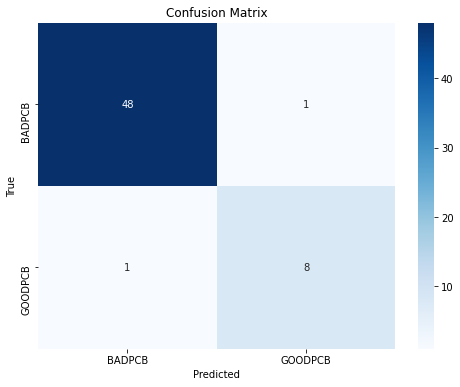


예측 실패한 이미지 출력


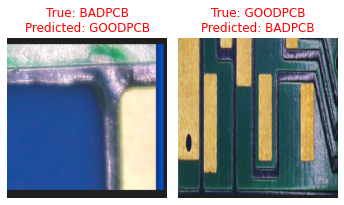

In [2]:
det = pcbDetection(clf="all")
y_pred = det.clfResult()

시스템 자체에서 정의한 테스트 데이터를 기반으로 결과를 출력하며, 평가 지표를 출력하며, 추론 결과를 return합니다.

loss, accuracy 출력
58/58 - 3s - loss: 0.0762 - accuracy: 0.9655 - 3s/epoch - 46ms/step
[0.07615629583597183, 0.9655172228813171]

classification Report 출력
              precision    recall  f1-score   support

      BADPCB       0.98      0.98      0.98        49
     GOODPCB       0.89      0.89      0.89         9

    accuracy                           0.97        58
   macro avg       0.93      0.93      0.93        58
weighted avg       0.97      0.97      0.97        58


confusion matrix 출력


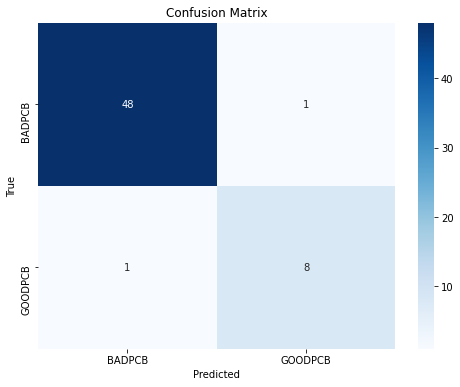


예측 실패한 이미지 출력


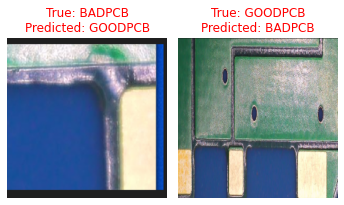

In [3]:
det = pcbDetection(clf="client1")
y_pred = det.clfResult()

시스템 자체에서 정의한 테스트 데이터를 기반으로 결과를 출력하며, 평가 지표를 출력하며, 추론 결과를 return합니다.

loss, accuracy 출력
58/58 - 3s - loss: 0.1034 - accuracy: 0.9828 - 3s/epoch - 48ms/step
[0.10343365371227264, 0.982758641242981]

classification Report 출력
              precision    recall  f1-score   support

      BADPCB       1.00      0.98      0.99        49
     GOODPCB       0.90      1.00      0.95         9

    accuracy                           0.98        58
   macro avg       0.95      0.99      0.97        58
weighted avg       0.98      0.98      0.98        58


confusion matrix 출력


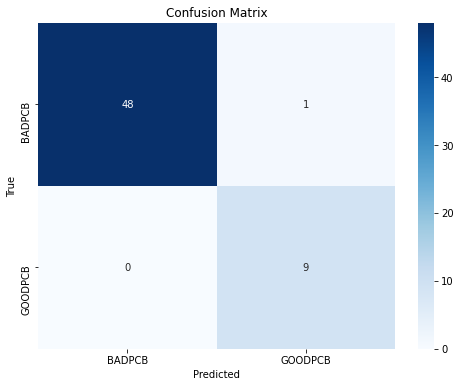


예측 실패한 이미지 출력


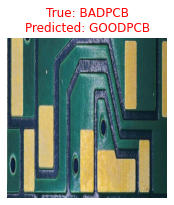

In [4]:
det = pcbDetection(clf="client2")
y_pred = det.clfResult()

## Object Detection Result (All)

In [3]:
det = pcbDetection(yolo="all")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/runs/train/PCB_train_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=PCB_result_final(central), exist_ok=True, half=False, dnn=False
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

requirements: AutoUpdate success ✅ 6.8s, installed 2 packages: ['gitpython>=3.1.30', 'setuptools>=65.5.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fu

In [4]:
det = pcbDetection(yolo="client1")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/C1_PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/runs/train/C1_PCB_train_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=C1_PCB_result_final(central), exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /home/work/KISTI_PCB2/C1_PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/C1_PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/C1_PCB/test/labels.cache... 49 images, 

In [5]:
det = pcbDetection(yolo="client2")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/C2_PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/runs/train/C2_PCB_train_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=C2_PCB_result_final(central), exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /home/work/KISTI_PCB2/C2_PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/C2_PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:01<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/C2_PCB/test/labels.cache... 49 images, 

In [6]:
det = pcbDetection(yolo="federated_1")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/model1_vMTRVgfDoeXTT6Dn.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=PCB_result_final(federated)_round1, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]

test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 

In [7]:
det = pcbDetection(yolo="federated_6")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/model6_vMTRVgfDoeXTT6Dn.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=PCB_result_final(federated)_round6, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 1

In [8]:
det = pcbDetection(yolo="federated_11")
det.yoloResult()

val: data=/home/work/KISTI_PCB2/PCB/PCB.yaml, weights=['/home/work/KISTI_PCB2/yolov5/model11_vMTRVgfDoeXTT6Dn.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=PCB_result_final(federated)_round11, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
test: Scanning /home/work/KISTI_PCB2/PCB/test/labels.cache... 49 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:20<?, ?it/s]

                 Class     Images  Instances          P          R      mAP50   mAP50-95:  50%|██

## 새로운 Test set에 대한 Image Classification Result(평가지표 포함)

In [ ]:
det = pcbDetection(
    clf="all", input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test", clf_isLabel=True
)
y_pred = det.clfResult()

In [ ]:
det = pcbDetection(
    clf="client1",
    input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test",
    clf_isLabel=True,
)
y_pred = det.clfResult()

In [ ]:
det = pcbDetection(
    clf="client2",
    input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test",
    clf_isLabel=True,
)
y_pred = det.clfResult()

## 새로운 Test set에 대한 Image Classification Result(예측값만 알고 싶은 경우)

In [ ]:
det = pcbDetection(
    clf="all", input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test", clf_isLabel=False
)
y_pred = det.clfResult()
y_pred

In [ ]:
det = pcbDetection(
    clf="client1",
    input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test",
    clf_isLabel=False,
)
y_pred = det.clfResult()
y_pred

In [ ]:
det = pcbDetection(
    clf="client2",
    input_img_dir="/home/work/KISTI_PCB2/C1_PCB_CLF/test",
    clf_isLabel=False,
)
y_pred = det.clfResult()
y_pred

## Image Classification -> Object Detection이 실행되는 Flow

In [19]:
det = pcbDetection(clf="client1", yolo="federated_11")
y_pred = det.predict()
print(y_pred)

[[0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]


In [20]:
det.save()
det.detect()

detect: weights=['/home/work/KISTI_PCB2/yolov5/model11_vMTRVgfDoeXTT6Dn.pt'], source=/home/work/KISTI_PCB2/result_clf_img/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/work/KISTI_PCB2/result_clf_img/, name=inference, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
image 1/49 /home/work/KISTI_PCB2/result_clf_img/images/BASIC_MATERIAL_SCRATCH_1.png: 640x288 15 SCRATCHs, 8.0ms
image 2/49 /home/work/KISTI_PCB2/result_clf_img/images/BASIC_MATERIAL_SCRATCH_25.png: 640x224 6 SCRATCHs, 8.3ms
image 3/49 /h

In [21]:
directory_path_save = "/home/work/KISTI_PCB2/result_clf_img/images"
directory_path_detect = "/home/work/KISTI_PCB2/result_clf_img/inference"

# 디렉토리에서 이미지 파일 찾기
image_files_save = glob.glob(os.path.join(directory_path_save, "*.png"))
image_files_detect = glob.glob(os.path.join(directory_path_detect, "*.png"))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, image_file in enumerate([image_files_save[0], image_files_detect[0]]):
    image = Image.open(image_file)
    ax[i].imshow(image)
    ax[i].set_title("Image {}".format(i + 1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)

plt.show()

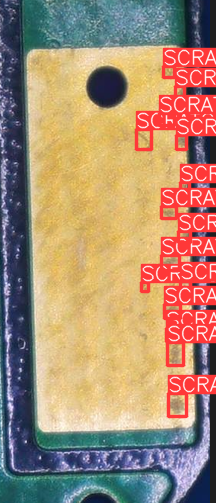

In [22]:
Image.open(image_files_detect[0])

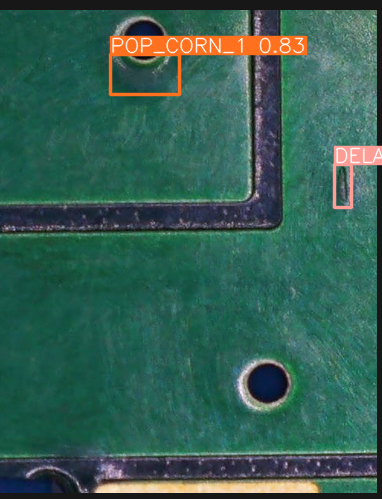

In [23]:
Image.open(image_files_detect[1])

In [16]:
det = pcbDetection(clf="client2", yolo="federated_11")
y_pred = det.predict()
print(y_pred)

[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]


In [17]:
det.save()
det.detect()

detect: weights=['/home/work/KISTI_PCB2/yolov5/model11_vMTRVgfDoeXTT6Dn.pt'], source=/home/work/KISTI_PCB2/result_clf_img/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/work/KISTI_PCB2/result_clf_img/, name=inference, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.8.10 torch-2.1.0+cu121 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 1764577 parameters, 0 gradients, 4.1 GFLOPs
image 1/48 /home/work/KISTI_PCB2/result_clf_img/images/BASIC_MATERIAL_SCRATCH_1.png: 640x288 15 SCRATCHs, 10.4ms
image 2/48 /home/work/KISTI_PCB2/result_clf_img/images/BASIC_MATERIAL_SCRATCH_25.png: 640x224 6 SCRATCHs, 10.6ms
image 3/48 

In [18]:
directory_path_save = "/home/work/KISTI_PCB2/result_clf_img/images"
directory_path_detect = "/home/work/KISTI_PCB2/result_clf_img/inference"

# 디렉토리에서 이미지 파일 찾기
image_files_save = glob.glob(os.path.join(directory_path_save, "*.png"))
image_files_detect = glob.glob(os.path.join(directory_path_detect, "*.png"))

# 상위 5개 이미지 파일 출력
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, image_file in enumerate([image_files_save[0], image_files_detect[0]]):
    image = Image.open(image_file)
    ax[i].imshow(image)
    ax[i].set_title("Image {}".format(i + 1))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)

plt.show()